In [1]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()


In [2]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = gluon.data.vision.datasets.ImageFolderDataset(data_dir)

In [3]:
batch_size = 256
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)
])
data_iter = gluon.data.DataLoader(
    pokemon.transform_first(transformer), batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

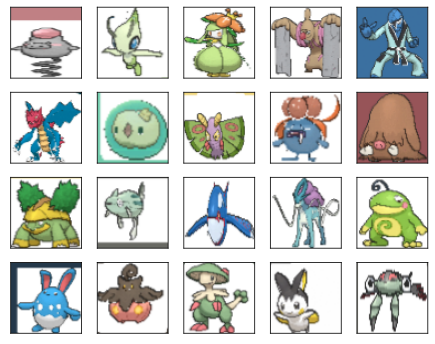

In [4]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].transpose(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [5]:
class G_block(nn.Block):
    def __init__(self, channels, kernel_size=4,
                 strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [6]:
x = np.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk.initialize()
g_blk(x).shape

(2, 20, 32, 32)

In [7]:
x = np.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk.initialize()
g_blk(x).shape

(2, 20, 4, 4)

In [8]:
n_G = 64
net_G = nn.Sequential()
net_G.add(G_block(n_G*8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
          G_block(n_G*4),  # Output: (64 * 4, 8, 8)
          G_block(n_G*2),  # Output: (64 * 2, 16, 16)
          G_block(n_G),   # Output: (64, 32, 32)
          nn.Conv2DTranspose(
              3, kernel_size=4, strides=2, padding=1, use_bias=False,
              activation='tanh'))  # Output: (3, 64, 64)

In [9]:
x = np.zeros((1, 100, 1, 1))
net_G.initialize()
net_G(x).shape

(1, 3, 64, 64)

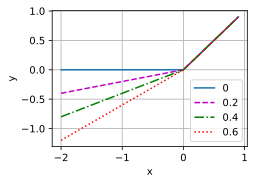

In [10]:
alphas = [0, 0.2, 0.4, .6, .8, 1]
x = np.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).asnumpy() for alpha in alphas]
d2l.plot(x.asnumpy(), Y, 'x', 'y', alphas)

In [11]:
class D_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [12]:
x = np.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk.initialize()
d_blk(x).shape

(2, 20, 8, 8)

In [13]:
n_D = 64
net_D = nn.Sequential()
net_D.add(D_block(n_D),   # Output: (64, 32, 32)
          D_block(n_D*2),  # Output: (64 * 2, 16, 16)
          D_block(n_D*4),  # Output: (64 * 4, 8, 8)
          D_block(n_D*8),  # Output: (64 * 8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # Output: (1, 1, 1)

In [14]:
x = np.zeros((1, 3, 64, 64))
net_D.initialize()
net_D(x).shape

(1, 1, 1, 1)

In [15]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = gluon.loss.SigmoidBCELoss()
    net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', trainer_hp)
    trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_ctx(device), Z.as_in_ctx(device),
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).transpose(0, 2, 3, 1) / 2 + 0.5
        imgs = np.concatenate(
            [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
             for i in range(len(fake_x)//7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.asnumpy())
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)